In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


pd.options.display.max_columns = 7
%matplotlib inline

In [2]:
train = pd.read_csv('training.csv')
train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,...,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,...,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,...,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,...,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,...,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,...,-999.000,0.000,6.245333,b


In [3]:
del(train['EventId'])
y = train['Label']
Weight = train['Weight']
del(train['Label'])
del(train['Weight'])
X = train

Fraction of 's' :  0.342668


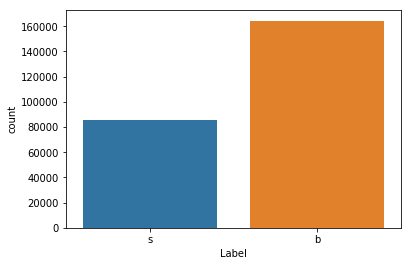

In [4]:
#Checking if the data is balanced
sns.countplot(y)
print "Fraction of 's' : ",float(sum(y=='s'))/len(y)

Clearly the data is imbalanced (34-66 distribution)

In [5]:
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,...,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000
mean,-49.023079,49.239819,81.181982,57.895962,...,-692.381204,-709.121609,-709.118631,73.064591
std,406.345647,35.344886,40.828691,63.655682,...,479.875496,453.384624,453.389017,98.015662
min,-999.000000,0.000000,6.329000,0.000000,...,-999.000000,-999.000000,-999.000000,0.000000
25%,78.100750,19.241000,59.388750,14.068750,...,-999.000000,-999.000000,-999.000000,0.000000
50%,105.012000,46.524000,73.752000,38.467500,...,-999.000000,-999.000000,-999.000000,40.512500
75%,130.606250,73.598000,92.259000,79.169000,...,33.703000,-2.457000,-2.275000,109.933750
max,1192.026000,690.075000,1349.351000,2834.999000,...,721.456000,4.500000,3.142000,1633.433000


In [6]:
#Filling in -999.00(Marker for empty feilds) values with median of the rest of the data in the column

imp = Imputer(missing_values=-999.00, strategy='median')
cols = X.columns
X = pd.DataFrame(imp.fit_transform(X), columns=cols)
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,...,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000
mean,120.417434,49.239819,81.181982,57.895962,...,50.739149,-0.010535,-0.001879,73.064591
std,52.859218,35.344886,40.828691,63.655682,...,17.792135,1.094446,0.978743,98.015662
min,9.044000,0.000000,6.329000,0.000000,...,30.000000,-4.500000,-3.142000,0.000000
25%,95.665000,19.241000,59.388750,14.068750,...,47.902000,-0.010000,-0.002000,0.000000
50%,112.406000,46.524000,73.752000,38.467500,...,47.902000,-0.010000,-0.002000,40.512500
75%,130.606250,73.598000,92.259000,79.169000,...,47.902000,-0.010000,-0.002000,109.933750
max,1192.026000,690.075000,1349.351000,2834.999000,...,721.456000,4.500000,3.142000,1633.433000


### Analysing outliers

In [8]:
X.describe(percentiles=[0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.991, 0.992, 0.995, 0.996, 0.999, 0.9995, 0.9999])

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,...,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000
mean,120.417434,49.239819,81.181982,57.895962,...,50.739149,-0.010535,-0.001879,73.064591
std,52.859218,35.344886,40.828691,63.655682,...,17.792135,1.094446,0.978743,98.015662
min,9.044000,0.000000,6.329000,0.000000,...,30.000000,-4.500000,-3.142000,0.000000
50%,112.406000,46.524000,73.752000,38.467500,...,47.902000,-0.010000,-0.002000,40.512500
70%,124.963300,68.731300,87.635000,67.917300,...,47.902000,-0.010000,-0.002000,91.820300
80%,137.205200,78.597000,97.734200,93.363000,...,47.902000,-0.010000,-0.002000,131.707200
85%,146.005150,84.238150,104.979000,111.648000,...,47.902000,-0.010000,-0.002000,159.115300
90%,160.890000,91.624200,117.101200,137.912300,...,57.708100,0.963000,0.980000,197.453900
95%,201.808000,104.644200,149.270050,183.491100,...,77.286050,2.152000,2.060000,263.951550


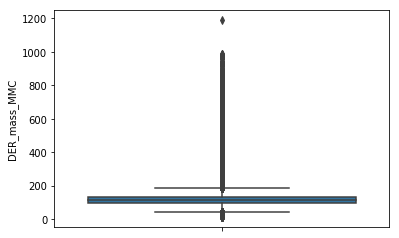

In [8]:
sns.boxplot(y = X['DER_mass_MMC'])

In [9]:
y[X['DER_mass_MMC']>=889].value_counts()

b    23
s     3
Name: Label, dtype: int64

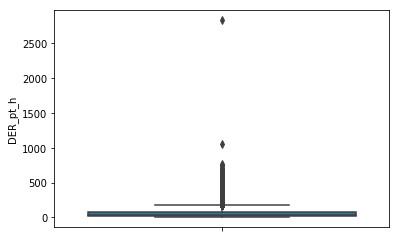

In [10]:
sns.boxplot(y = X['DER_pt_h'])

In [11]:
y[X['DER_pt_h']>=596].value_counts()

s    19
b     7
Name: Label, dtype: int64

In [13]:
X.describe(percentiles=[0.9999])

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,...,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000
mean,120.417434,49.239819,81.181982,...,-0.010535,-0.001879,73.064591
std,52.859218,35.344886,40.828691,...,1.094446,0.978743,98.015662
min,9.044000,0.000000,6.329000,...,-4.500000,-3.142000,0.000000
50%,112.406000,46.524000,73.752000,...,-0.010000,-0.002000,40.512500
99.99%,889.698197,418.616078,664.854606,...,4.463000,3.139000,1098.724034
max,1192.026000,690.075000,1349.351000,...,4.500000,3.142000,1633.433000


In [16]:
#Points above the 99.99 percentile are considered as outlier

col_cutoff = {'DER_mass_MMC' : 890, 'DER_mass_vis' : 665, 'DER_pt_h' : 597, 'DER_mass_jet_jet' : 3334, 'DER_pt_tot' : 274, 'DER_sum_pt' : 1246, 
       'PRI_tau_pt' : 350, 'PRI_lep_pt' : 336, 'PRI_met' : 416, 'PRI_met_sumet' : 1316, 'PRI_jet_leading_pt' : 618, 'PRI_jet_subleading_pt' :385,
       'PRI_jet_all_pt' : 1099}

for col,cutoff in col_cutoff.iteritems():
    y = y[ X[col] <= cutoff]
    Weight = Weight[ X[col] <= cutoff ]
    X = X[ X[col] <= cutoff]

"    \ny = y[ X['DER_mass_MMC']<=890 ]\ny = y[ X['DER_mass_vis']<=665 ]\ny = y[ X['DER_pt_h']<=597 ]\ny = y[ X['DER_mass_jet_jet']<=3334 ]\ny = y[ X['DER_pt_tot']<=274 ]\ny = y[ X['DER_sum_pt']<=1246 ]\ny = y[ X['PRI_tau_pt']<=350 ]\ny = y[ X['PRI_lep_pt']<=336 ]\ny = y[ X['PRI_met']<=416 ]\ny = y[ X['PRI_met_sumet']<=1316 ]\ny = y[ X['PRI_jet_leading_pt']<=618 ]\ny = y[ X['PRI_jet_subleading_pt']<=385 ]\ny = y[ X['PRI_jet_all_pt']<=1099 ]\n\nWeight = Weight[ X['DER_mass_MMC']<=890 ]\nWeight = Weight[ X['DER_mass_vis']<=665 ]\nWeight = Weight[ X['DER_pt_h']<=597 ]\nWeight = Weight[ X['DER_mass_jet_jet']<=3334 ]\nWeight = Weight[ X['DER_pt_tot']<=274 ]\nWeight = Weight[ X['DER_sum_pt']<=1246 ]\nWeight = Weight[ X['PRI_tau_pt']<=350 ]\nWeight = Weight[ X['PRI_lep_pt']<=336 ]\nWeight = Weight[ X['PRI_met']<=416 ]\nWeight = Weight[ X['PRI_met_sumet']<=1316 ]\nWeight = Weight[ X['PRI_jet_leading_pt']<=618 ]\nWeight = Weight[ X['PRI_jet_subleading_pt']<=385 ]\nWeight = Weight[ X['PRI_jet_all

In [17]:
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,...,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,249789.000000,249789.000000,249789.000000,...,249789.000000,249789.000000,249789.000000
mean,120.297204,49.208626,81.075247,...,-0.010585,-0.002048,72.653455
std,51.972573,35.147266,39.921504,...,1.093559,0.977951,96.415752
min,9.044000,0.000000,6.329000,...,-4.500000,-3.142000,-0.000000
25%,95.658000,19.249000,59.393000,...,-0.010000,-0.002000,0.000000
50%,112.406000,46.527000,73.750000,...,-0.010000,-0.002000,40.452000
75%,130.595000,73.587000,92.242000,...,-0.010000,-0.002000,109.704000
max,889.698000,570.115000,664.854000,...,4.500000,3.142000,1092.209000


In [18]:
#Since the values are still large in many of the columns, we aplly log to columns with all positive values
cols = X.columns
X = np.array(X)
log_cols = [0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]
X[:, log_cols] = np.log(1 + X[:, log_cols])
X = pd.DataFrame(X, columns=cols)
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,...,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,249789.000000,249789.000000,249789.000000,...,249789.000000,249789.000000,249789.000000
mean,4.733318,3.555713,4.318895,...,-0.010585,-0.002048,2.725681
std,0.350283,1.007721,0.413730,...,1.093559,0.977951,2.292841
min,2.306975,0.000000,1.991839,...,-4.500000,-3.142000,0.000000
25%,4.571179,3.008105,4.100873,...,-0.010000,-0.002000,0.000000
50%,4.730974,3.861298,4.314149,...,-0.010000,-0.002000,3.724536
75%,4.879729,4.311966,4.535198,...,-0.010000,-0.002000,4.706860
max,6.792005,6.347591,6.501070,...,4.500000,3.142000,6.996873


In [19]:
#Some features still have a high deviation. Hence scaling all the features

scaler = StandardScaler()
cols = X.columns
X = pd.DataFrame(scaler.fit_transform(X), columns=cols)
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,...,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,2.497890e+05,2.497890e+05,2.497890e+05,...,2.497890e+05,2.497890e+05,2.497890e+05
mean,-1.763400e-15,6.836928e-17,-3.577063e-15,...,-6.115829e-17,-1.237958e-16,-2.188045e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00
min,-6.926829e+00,-3.528477e+00,-5.624586e+00,...,-4.105333e+00,-3.210753e+00,-1.188782e+00
25%,-4.628805e-01,-5.434129e-01,-5.269668e-01,...,5.349093e-04,4.883723e-05,-1.188782e+00
50%,-6.689762e-03,3.032443e-01,-1.147031e-02,...,5.349093e-04,4.883723e-05,4.356415e-01
75%,4.179818e-01,7.504605e-01,5.228140e-01,...,5.349093e-04,4.883723e-05,8.640733e-01
max,5.877233e+00,2.770492e+00,5.274405e+00,...,4.124692e+00,3.214941e+00,1.862842e+00


In [35]:
#Functions to calculate ams score
def ams(s, b):
    return math.sqrt(2 * ((s + b + 10) * math.log(1.0 + s/(b + 10)) - s))

def get_ams_score(W, Y, Y_pred):
    s = W * (Y == 1) * (Y_pred == 1)
    b = W * (Y == 0) * (Y_pred == 1)
    s = np.sum(s)
    b = np.sum(b)
    return ams(s, b)

In [21]:
X = np.array(X)
y = np.array(y=='s', dtype=int)
Weight = np.array(Weight)

train_X = X[:220000 , :]
train_y = y[:220000]
train_Weight = Weight[:220000]

val_X = X[220000:, :]
val_y = y[220000:]
val_Weight = Weight[220000:]

In [22]:
print train_X.shape
print train_y.shape
print train_Weight.shape

print val_X.shape
print val_y.shape
print val_Weight.shape

(220000, 30)
(220000,)
(220000,)
(29789, 30)
(29789,)
(29789,)


In [23]:
def print_best_asm(val_y_pred):
    thresholds = np.arange(75,95)
    ams_scores = []

    for threshold in thresholds:
        limit = np.percentile(val_y_pred, threshold)
        val_y_thesholded = val_y_pred > limit
        score = get_ams_score(val_Weight, val_y, val_y_thesholded)
        ams_scores.append(score)

    print "Best ams score of ",max(ams_scores)," at threshold of ",thresholds[np.argmax(ams_scores)]

In [36]:
params = {
    'n_estimators' : [300, 400, 500],
    'max_features' : [20, 25, 30],
    'max_depth' : [10, 12, 15],
    'min_samples_split' : [50, 100, 150],
    'min_samples_leaf' : [50, 100, 150]
}

#etc = GridSearchCV(ExtraTreesClassifier(), params, verbose=True, n_jobs=-1)
#etc.fit(train_X, train_y, sample_weight=train_Weight)
#print etc.best_params_

etc = ExtraTreesClassifier(class_weight='balanced', n_estimators = 400, max_features = 30, max_depth = 15, min_samples_leaf = 100, min_samples_split = 100, n_jobs = -1)
etc.fit(train_X, train_y, sample_weight=train_Weight)


val_y_pred = etc.predict_proba(val_X)[:,1]

print_best_asm(val_y_pred)

Best ams score of  1.13978338442  at threshold of  82


In [37]:
mlp1 = MLPClassifier(hidden_layer_sizes=(50, 100, 50), early_stopping=True)
mlp1.fit(train_X, train_y)



val_y_pred = mlp1.predict_proba(val_X)[:,1]

print_best_asm(val_y_pred)

Best ams score of  1.1573703186  at threshold of  84


In [38]:
mlp2 = MLPClassifier(hidden_layer_sizes=(50, 100, 200, 100, 50), early_stopping=True)
mlp2.fit(train_X, train_y)



val_y_pred = mlp2.predict_proba(val_X)[:,1]

print_best_asm(val_y_pred)

Best ams score of  1.18031877587  at threshold of  84


In [39]:
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=400, learning_rate=0.1, n_jobs=-1)
gbm.fit(train_X, train_y)

val_y_pred = gbm.predict_proba(val_X)[:,1]

print_best_asm(val_y_pred)

Best ams score of  1.19057196384  at threshold of  82


In [41]:
vc = VotingClassifier(estimators=[('mlp1', mlp1) , ('mlp2', mlp2)], voting='soft')
vc.fit(train_X, train_y)

val_y_pred = vc.predict_proba(val_X)[:,1]

print_best_asm(val_y_pred)

Best ams score of  1.2015355523  at threshold of  86


In [42]:
ada_etc = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, base_estimator=etc)
ada_etc.fit(train_X, train_y, sample_weight=train_Weight)


val_y_pred = ada_etc.predict_proba(val_X)[:,1]

print_best_asm(val_y_pred)

Best ams score of  1.25528128818  at threshold of  86


In [43]:
test_data = pd.read_csv('test.csv')
test_data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,...,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,...,-999.000,-999.000,-0.000
1,350001,106.398,67.490,...,-999.000,-999.000,47.575
2,350002,117.794,56.226,...,-999.000,-999.000,0.000
3,350003,135.861,30.604,...,-999.000,-999.000,0.000
4,350004,74.159,82.772,...,0.335,2.587,599.213


In [44]:
event_id = test_data['EventId']
del(test_data['EventId'])

In [45]:
test_X = imp.transform(test_data)

In [46]:
test_X = np.array(test_X)
log_cols = [0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]
test_X[:, log_cols] = np.log(1 + test_X[:, log_cols])

In [47]:
test_X = scaler.transform(test_X)

In [48]:
rank_order = np.arange(1,len(event_id)+1)
rank_order.shape

(550000,)

In [49]:
ada_etc.fit(X, y, sample_weight=Weight)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=15, max_features=30,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=100,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          learning_rate=0.1, n_estimators=50, random_state=None)

In [50]:
test_pred = ada_etc.predict_proba(test_X)[:,1]

In [51]:
limit = np.percentile(test_pred, 85)
test_pred_thresholded = test_pred > limit

sub_ada = pd.DataFrame( {"EventId" : list(event_id) , "RankOrder" : list(rank_order), "Class" : list(test_pred_thresholded)})
sub_ada['Class'] = sub_ada['Class'].apply(lambda x : 's' if x==1 else 'b')
sub_ada.to_csv('sub.csv', index=False)